In [1]:
# Jupyter Notebook - 代码

# 导入必要的库
import matplotlib.pyplot as plt
import numpy as np
import os,shutil
import tensorflow as tf
import seaborn as sns
from tqdm import tqdm
import datetime
import tensorflow_model_optimization as tfmot
from lib import AU
# 设定日志级别
tf.get_logger().setLevel('ERROR')

# 🔹 超参数
IMG_SIZE = (96, 96)
AUTOTUNE = tf.data.AUTOTUNE
IMG_SHAPE = IMG_SIZE + (3,)

In [2]:
# 检查缓存目录是否存在并删除
folder = 'cache'

if os.path.exists(folder) and os.path.isdir(folder):
    try:
        shutil.rmtree(folder)
        print(f"成功删除目录: {folder}")
    except Exception as e:
        print(f"删除失败，错误信息: {e}")
else:
    print(f"目录 '{folder}' 不存在")

成功删除目录: cache


阶段一

In [3]:
# 🔹 数据集路径
cache_dir = os.path.join('cache')
os.makedirs(cache_dir, exist_ok=True)

base_dir = './dataset'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'val')

BATCH_SIZE = 32
# 🔹 加载数据集
train_dataset_raw = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, 
    # validation_split=0.2, 
    # subset="training", 
    # seed=12,
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE)

validation_dataset_raw = tf.keras.preprocessing.image_dataset_from_directory(
    valid_dir, 
    # validation_split=0.2, 
    # subset="validation", 
    # seed=12,
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE)

class_names = train_dataset_raw.class_names
print("Class Names:", class_names)


# 加载数据集
train_dataset = (train_dataset_raw
                 .map(AU.preprocess_image, num_parallel_calls=AUTOTUNE)
                 .cache(os.path.join(cache_dir, 'train_cache1')) # 缓存到文件
                 .shuffle(1000)
                 .prefetch(AUTOTUNE))

validation_dataset = (validation_dataset_raw
                      .map(AU.preprocess_image, num_parallel_calls=AUTOTUNE)
                      .cache(os.path.join(cache_dir, 'val_cache1'))
                      .prefetch(AUTOTUNE))


Found 200000 files belonging to 10 classes.
Found 40000 files belonging to 10 classes.
Class Names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [4]:
# 🔹 构建模型

base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE, 
    include_top=False, 
    pooling = 'avg', 
    alpha=0.35, 
    weights='imagenet')

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])
model.build((None, 96, 96, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 mobilenetv2_0.35_96 (Functi  (None, 1280)             410208    
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 423,018
Trainable params: 408,938
Non-trainable params: 14,080
_________________________________________________________________


In [5]:
# 编译模型
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.00001, decay_steps=len(train_dataset)*5, decay_rate=0.99, staircase=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history1 = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=100, 
                    callbacks=[early_stopping]
                    )


Epoch 1/100
6250/6250 [==============================] - 376s 57ms/step - loss: 0.3895 - accuracy: 0.8828 - val_loss: 0.0329 - val_accuracy: 0.9915
Epoch 2/100
6250/6250 [==============================] - 393s 62ms/step - loss: 0.0327 - accuracy: 0.9909 - val_loss: 0.0104 - val_accuracy: 0.9972
Epoch 3/100
6250/6250 [==============================] - 391s 61ms/step - loss: 0.0134 - accuracy: 0.9963 - val_loss: 0.0069 - val_accuracy: 0.9979
Epoch 4/100
6250/6250 [==============================] - 380s 60ms/step - loss: 0.0071 - accuracy: 0.9983 - val_loss: 0.0051 - val_accuracy: 0.9983
Epoch 5/100
6250/6250 [==============================] - 411s 64ms/step - loss: 0.0040 - accuracy: 0.9992 - val_loss: 0.0043 - val_accuracy: 0.9985
Epoch 6/100
6250/6250 [==============================] - 406s 64ms/step - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.0041 - val_accuracy: 0.9987
Epoch 7/100
6250/6250 [==============================] - 403s 63ms/step - loss: 0.0015 - accuracy: 0.9997 - val_

阶段二

In [ ]:
# 🔹 数据集路径

cache_dir = os.path.join('cache')                                                                       
os.makedirs(cache_dir, exist_ok=True)

base_dir = './dataset'
train_dir = os.path.join(base_dir, 'train2')
valid_dir = os.path.join(base_dir, 'val')

BATCH_SIZE = 128
# 🔹 加载数据集
train_dataset_raw = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, 
    # validation_split=0.2, 
    # subset="training", 
    # seed=12,
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE)

validation_dataset_raw = tf.keras.preprocessing.image_dataset_from_directory(
    valid_dir, 
    # validation_split=0.2, 
    # subset="validation", 
    # seed=12,
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE)

class_names = train_dataset_raw.class_names
print("Class Names:", class_names)


# 加载数据集
train_dataset = (train_dataset_raw
                 .map(AU.preprocess_image, num_parallel_calls=AUTOTUNE)
                 .cache(os.path.join(cache_dir, 'train_cache2')) # 缓存到文件
                 .shuffle(1000)
                 .prefetch(AUTOTUNE))

validation_dataset = (validation_dataset_raw
                      .map(AU.preprocess_image, num_parallel_calls=AUTOTUNE)
                      .cache(os.path.join(cache_dir, 'val_cache2'))
                      .prefetch(AUTOTUNE))


In [ ]:
# 编译模型
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.00001, decay_steps=len(train_dataset)*5, decay_rate=0.99, staircase=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history2 = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=200, 
                    callbacks=[early_stopping]
                    )

阶段三

In [ ]:
# 🔹 数据集路径
cache_dir = os.path.join('cache')
os.makedirs(cache_dir, exist_ok=True)

base_dir = './dataset'
train_dir = os.path.join(base_dir, 'train3')
valid_dir = os.path.join(base_dir, 'val')

BATCH_SIZE = 128
# 🔹 加载数据集
train_dataset_raw = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, 
    # validation_split=0.2, 
    # subset="training", 
    # seed=12,
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE)

validation_dataset_raw = tf.keras.preprocessing.image_dataset_from_directory(
    valid_dir, 
    # validation_split=0.2, 
    # subset="validation", 
    # seed=12,
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE)

class_names = train_dataset_raw.class_names
print("Class Names:", class_names)


# 加载数据集
train_dataset = (train_dataset_raw
                 .map(AU.preprocess_image, num_parallel_calls=AUTOTUNE)
                 .cache(os.path.join(cache_dir, 'train_cache3')) # 缓存到文件
                 .shuffle(1000)
                 .prefetch(AUTOTUNE))

validation_dataset = (validation_dataset_raw
                      .map(AU.preprocess_image, num_parallel_calls=AUTOTUNE)
                      .cache(os.path.join(cache_dir, 'val_cache3'))
                      .prefetch(AUTOTUNE))


In [ ]:
# 编译模型
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.00001, decay_steps=len(train_dataset)*5, decay_rate=0.99, staircase=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history3 = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=100, 
                    callbacks=[early_stopping]
                    )

阶段四

In [6]:
# 🔹 数据集路径
cache_dir = os.path.join('cache')
os.makedirs(cache_dir, exist_ok=True)

base_dir = './dataset'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'val')

BATCH_SIZE = 32
# 🔹 加载数据集
train_dataset_raw = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, 
    # validation_split=0.2, 
    # subset="training", 
    # seed=12,
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE)

validation_dataset_raw = tf.keras.preprocessing.image_dataset_from_directory(
    valid_dir, 
    # validation_split=0.2, 
    # subset="validation", 
    # seed=12,
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE)

class_names = train_dataset_raw.class_names
print("Class Names:", class_names)


# 加载数据集
train_dataset = (train_dataset_raw
                 .map(AU.preprocess_image_aug, num_parallel_calls=AUTOTUNE)
                 .cache(os.path.join(cache_dir, 'train_cache4')) # 缓存到文件
                 .shuffle(1000)
                 .prefetch(AUTOTUNE))

validation_dataset = (validation_dataset_raw
                      .map(AU.preprocess_image, num_parallel_calls=AUTOTUNE)
                      .cache(os.path.join(cache_dir, 'val_cache4'))
                      .prefetch(AUTOTUNE))


Found 200000 files belonging to 10 classes.
Found 40000 files belonging to 10 classes.
Class Names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [7]:
# 编译模型
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.00001, decay_steps=len(train_dataset)*5, decay_rate=0.99, staircase=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# 训练第一阶段
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

history4 = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=100, 
                    callbacks=[early_stopping]
                    )

Epoch 1/100
6250/6250 [==============================] - 443s 68ms/step - loss: 0.0043 - accuracy: 0.9985 - val_loss: 0.0037 - val_accuracy: 0.9987
Epoch 2/100
6250/6250 [==============================] - 555s 87ms/step - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.0036 - val_accuracy: 0.9986
Epoch 3/100
6250/6250 [==============================] - 555s 87ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.0036 - val_accuracy: 0.9990
Epoch 4/100
6250/6250 [==============================] - 555s 87ms/step - loss: 7.3993e-04 - accuracy: 0.9998 - val_loss: 0.0035 - val_accuracy: 0.9988
Epoch 5/100
6250/6250 [==============================] - 554s 87ms/step - loss: 4.4620e-04 - accuracy: 0.9999 - val_loss: 0.0045 - val_accuracy: 0.9988
Epoch 6/100
6250/6250 [==============================] - 554s 87ms/step - loss: 3.6490e-04 - accuracy: 0.9999 - val_loss: 0.0053 - val_accuracy: 0.9984


In [8]:
# 🔹 直接导出为TFLite格式 (无需保存H5)
def representative_dataset():
    # 从验证集取500个批次作为量化校准数据
    for images, _ in tqdm(validation_dataset.take(500), desc="Calibration"):
        yield [tf.cast(images, tf.float32)]  # 输入需为浮点型

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8   # 输入为uint8 (0-255)
converter.inference_output_type = tf.uint8  # 输出为uint8类别索引

tflite_model = converter.convert()

output_dir = './model'
os.makedirs(output_dir, exist_ok=True)  # 自动创建目录（如果不存在）
# 保存带时间戳的TFLite模型
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
output_path = f'./model/qat_model_{timestamp}.tflite'
with open(output_path, 'wb') as f:
    f.write(tflite_model)

print(f"TFLite模型已保存至: {output_path}")

target_dir = "model"
# 直接匹配当前目录下的 .h5 文件
for file in os.listdir(target_dir):
    if file.endswith(".h5"):
        file_path = os.path.join(target_dir, file)
        try:
            os.remove(file_path)
            print(f"已删除: {file_path}")
        except Exception as e:
            print(f"删除失败 [{file_path}]: {e}")

d:\miniconda\envs\tf\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
Calibration: 100%|██████████| 500/500 [03:13<00:00,  2.59it/s]


TFLite模型已保存至: ./model/qat_model_20250414_2349.tflite


1250/1250 [==============================] - 41s 32ms/step


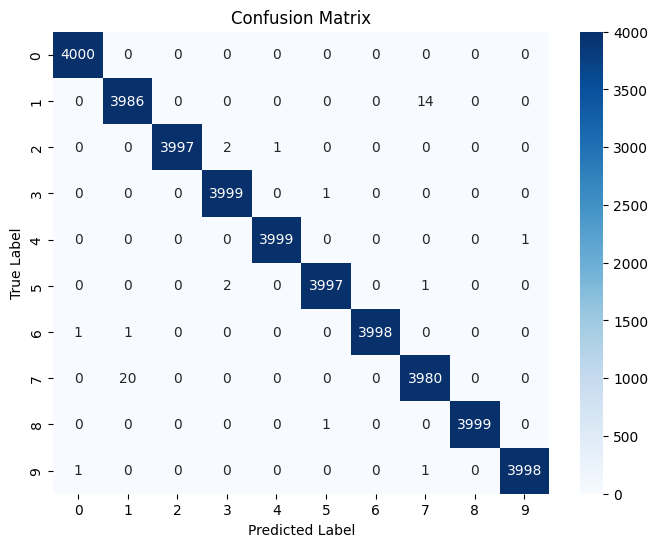

In [9]:
from sklearn.metrics import confusion_matrix
# 混淆矩阵
y_pred = np.argmax(model.predict(validation_dataset), axis=1)
y_true = np.concatenate([labels.numpy() for _, labels in validation_dataset])

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from lib import polt_improved

stage_names = ["history"]
history_list = [history1,history4]
polt_improved.plot_combined_curves_improved(history_list)